In [1]:
# Preamble (system)
import sys
import os

if sys.version_info[0] < 3:
  raise AssertionError('Please run this notebook with Python 3.')

# Preamble (tools)
import numpy as np
import collections
import contextlib
import functools
import itertools
import more_itertools

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Preamble (ML)
np.random.seed(2027)  # set random seed

import tensorflow as tf
tf.random.set_seed(2027)  # set random seed

#import dask
#import dask.array as da

In [2]:
# Preamble (EMTF)
from emtf_nbtools import get_logger, get_colormap, emtf_nbtools

try:
  import emtf_nnet
except ImportError:
  raise ImportError('Could not import emtf_nnet. It can be found at '
                    'https://github.com/jiafulow/emtf-nnet')

# Get plot style and color map
plt.style.use('tdrstyle.mplstyle')
cm = get_colormap()

# Get logger
logger = get_logger()
logger.info('Using cmssw      : {}'.format(os.environ.get('CMSSW_VERSION', 'N/A')))
logger.info('Using python     : {}'.format(sys.version.replace('\n', '')))
logger.info('Using numpy      : {}'.format(np.__version__))
logger.info('Using matplotlib : {}'.format(matplotlib.__version__))
logger.info('Using tensorflow : {}'.format(tf.__version__))
logger.info('Using keras      : {}'.format(tf.keras.__version__))
logger.info('.. list devices  : {}'.format(tf.config.list_physical_devices()))
#logger.info('Using dask       : {}'.format(dask.__version__))
logger.info('Using emtf-nnet  : {}'.format(emtf_nnet.__version__))

[INFO    ] Using cmssw      : CMSSW_11_1_7
[INFO    ] Using python     : 3.9.7 (default, Sep 16 2021, 13:09:58) [GCC 7.5.0]
[INFO    ] Using numpy      : 1.20.3
[INFO    ] Using matplotlib : 3.4.2
[INFO    ] Using tensorflow : 2.6.0
[INFO    ] Using keras      : 2.6.0
2021-10-16 14:33:59.331268: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
[INFO    ] .. list devices  : [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
2021-10-16 14:33:59.331305: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (login1.ufhpc): /proc/driver/nvidia/version does not exist
[INFO    ] Using emtf-nnet  : 0.0.2-dev


In [3]:
# Preamble (ML additional stuff)
import h5py
import pandas as pd
import seaborn as sns

#import tensorflow_probability as tfp
#import tensorflow_model_optimization as tfmot

In [4]:
# Settings

# zone: (0,1,2) -> eta=(1.98..2.5, 1.55..1.98, 1.2..1.55)
zone = 0
#zone = 1
#zone = 2

# timezone: (0,1,2) -> BX=(0,-1,-2)
timezone = 0

maxevents = 10_000
#maxevents = -1

# NN pruning: True/False
do_pruning = False

# NN quantization: True/False
do_quantization = False

# Input files
features_fname = 'features.211016.h5'

logger.info('Using settings   : |')
logger.info('.. zone          : {}'.format(zone))
logger.info('.. timezone      : {}'.format(timezone))
logger.info('.. maxevents     : {}'.format(maxevents))

[INFO    ] Using settings   : |
[INFO    ] .. zone          : 0
[INFO    ] .. timezone      : 0
[INFO    ] .. maxevents     : 10000


### Load data

In [5]:
def load_features(fname):
  logger.info('Loading from {}'.format(fname))
  with h5py.File(fname, 'r') as loaded:
    features = np.array(loaded['features'])
    truths = np.array(loaded['truths'])
    noises = np.array(loaded['noises'])
  logger.info('features: {} truths: {} noises: {}'.format(
      (features.shape, features.dtype.name),
      (truths.shape, truths.dtype.name),
      (noises.shape, noises.dtype.name)))
  return (features, truths, noises)

In [6]:
# Load features and truths
features, truths, noises = load_features(features_fname)

[INFO    ] Loading from features.211016.h5
[INFO    ] features: ((1641819, 40), 'int32') truths: ((1641819, 10), 'float32') noises: ((1407704, 40), 'int32')


In [7]:
from emtf_nnet.architecture import endless_nnet_v3

tf.config.optimizer.set_jit(True)  # enable XLA
#tf.config.threading.set_inter_op_parallelism_threads(32)
#tf.config.threading.set_intra_op_parallelism_threads(32)

# Split into train/test
x_train, x_test, y_train, y_test = endless_nnet_v3.get_x_y_data(
    features, truths, batch_size=8192)
logger.info('x_train: {} y_train: {} x_test: {} y_test: {}'.format(
    x_train.shape, y_train.shape, x_test.shape, y_test.shape))

[INFO    ] x_train: (1236992, 40) y_train: (1236992, 1) x_test: (404827, 40) y_test: (404827, 1)


### Create model

In [8]:
# Set hyperparameters
learning_rate = 0.005
final_learning_rate = learning_rate * 0.02
gradient_clipnorm = 10.
warmup_epochs = 30
epochs = warmup_epochs + 120
batch_size = 2048

num_train_samples = x_train.shape[0]
callbacks = [emtf_nnet.keras.callbacks.LearningRateLogger(),]
logger.info('learning_rate: {} final_learning_rate: {} epochs: {} batch_size: {}'.format(
    learning_rate, final_learning_rate, epochs, batch_size))

# Create model
preprocessing_layer = endless_nnet_v3.create_preprocessing_layer(x_train)
regularization_layer = endless_nnet_v3.create_regularization_layer(noises, batch_size=batch_size)
lr_schedule = endless_nnet_v3.create_lr_schedule(
    num_train_samples, epochs=epochs, warmup_epochs=warmup_epochs, batch_size=batch_size,
    learning_rate=learning_rate, final_learning_rate=final_learning_rate)
optimizer = endless_nnet_v3.create_optimizer(
    lr_schedule, gradient_clipnorm=gradient_clipnorm)
model = endless_nnet_v3.create_model(
    preprocessing_layer, regularization_layer, optimizer)
model.summary()

[INFO    ] learning_rate: 0.005 final_learning_rate: 0.0001 epochs: 150 batch_size: 2048
2021-10-16 14:34:09.616604: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "nnet_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocessing (FeatureNormal (None, 40)                80        
_________________________________________________________________
dense (MutatedDense)         (None, 28)                1120      
_________________________________________________________________
batch_normalization (Mutated (None, 28)                112       
_________________________________________________________________
activation (TanhActivation)  (None, 28)                0         
_________________________________________________________________
dense_1 (MutatedDense)       (None, 24)                672       
_________________________________________________________________
batch_normalization_1 (Mutat (None, 24)                96        
_________________________________________________________________
activation_1 (TanhActivation (None, 24)                0

### Train model

In [9]:
# Training utils
class HistoryPlotter(object):
  def __init__(self, history, metric=None):
    self.history = history
    if metric is None:
      metric = 'loss'
    self.metric = metric

  def plot(self):
    train_value = self.history.history[self.metric]
    val_value = self.history.history['val_' + self.metric]
    lr_value = self.history.history['lr']
    maxnorm_value = self.history.history['gradient_maxnorm']
    tup = (len(self.history.epoch), len(self.history.epoch), self.metric,
           train_value[-1], 'val_' + self.metric, val_value[-1])
    logger.info('Epoch {}/{} - {}: {:.4f} - {}: {:.4f}'.format(*tup))

    if len(self.history.epoch) > 10:
      fig, axs = plt.subplots(1, 2, figsize=(6, 6/2), tight_layout=True)
      ax = axs[0]
      ax.plot(self.history.epoch, lr_value, color='C0')
      ax.set_xlabel('Epochs')
      ax.set_ylabel('Learning rate')
      ax.grid(True)
      ax = axs[1]
      ax.plot(self.history.epoch, train_value, color='C0', label='Train')
      ax.plot(self.history.epoch, val_value, '--', color='C0', label='Val')
      ax.set_xlabel('Epochs')
      ax.set_ylabel(self.metric.replace('_', ' ').title())
      ax.set_ylim(0, 1.5)
      ax.legend(loc='upper right')
      ax.grid(True)
      plt.show()

      fig, axs = plt.subplots(1, 2, figsize=(6, 6/2), tight_layout=True)
      ax = axs[0]
      ax.plot(self.history.epoch, maxnorm_value, color='C0')
      ax.set_xlabel('Epochs')
      ax.set_ylabel('Gradient maxnorm')
      ax.set_ylim(0, 1.5)
      ax.grid(True)
      plt.show()


class ModelTrainer(object):
  def __init__(self, model, log_dir='keras_logs', prefix='', suffix='.log'):
    self.model = model
    self.log_dir = log_dir
    self.prefix = prefix
    self.suffix = suffix

  def fit(self, *args, **kwargs):
    from datetime import datetime
    import tempfile
    if not os.path.exists(self.log_dir):
      os.makedirs(self.log_dir)
    fd, name = tempfile.mkstemp(prefix=self.prefix, suffix=self.suffix, dir=self.log_dir, text=True)

    start_time = datetime.now()
    logger.info('Begin training ...')

    # Fit
    with os.fdopen(fd, 'w') as f:
      with contextlib.redirect_stdout(f):
        history = self.model.fit(*args, **kwargs)
    logger.info('Done training. Time elapsed: {}'.format(str(datetime.now() - start_time)))

    # Plot history
    HistoryPlotter(history).plot()
    return history

[INFO    ] Begin training ...
2021-10-16 14:34:10.748234: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-16 14:34:12.456304: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x2b911c0a33b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-10-16 14:34:12.456348: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Host, Default Version
2021-10-16 14:34:12.464883: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2021-10-16 14:34:12.496531: I tensorflow/compiler/jit/xla_compilation_cache.cc:363] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
[INFO    ] Done training. Time elapsed: 0:09:35.550032
[INFO    ] Epoch 150/150 - loss: 0.0641 - val_loss: 0.0643


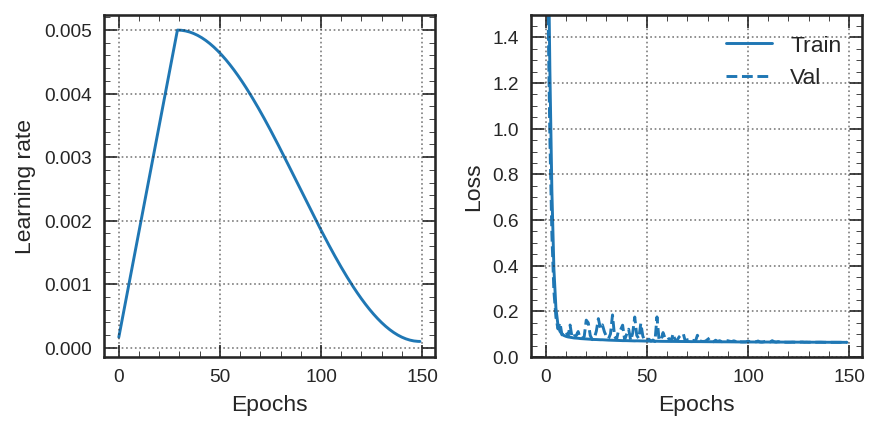

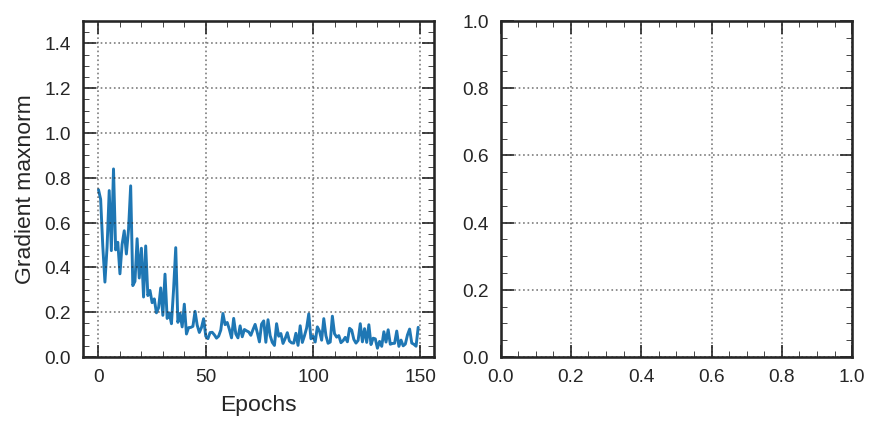

[INFO    ] Saved as nnet_model.h5


In [10]:
# Train model
history = ModelTrainer(model).fit(
    x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,
    callbacks=callbacks, validation_data=(x_test, y_test), shuffle=True)

# Save model
base_model = model
emtf_nnet.keras.utils.save_nnet_model(model)
logger.info('Saved as {}'.format(model.name + '.h5'))

### Pruning

In [11]:
# Create and train pruned model (1)
if do_pruning:
  pruning_callbacks = callbacks + [emtf_nnet.keras.sparsity.UpdatePruningStep()]
  pruning_learning_rate = learning_rate * 0.2
  pruning_epochs = 10
  pruning_schedule = endless_nnet_v3.create_pruning_schedule(
      num_train_samples, epochs=pruning_epochs, batch_size=batch_size)

  lr_schedule = endless_nnet_v3.create_lr_schedule(
      num_train_samples, epochs=pruning_epochs, warmup_epochs=0, batch_size=batch_size,
      learning_rate=pruning_learning_rate, final_learning_rate=pruning_learning_rate)
  optimizer = endless_nnet_v3.create_optimizer(
      lr_schedule, gradient_clipnorm=gradient_clipnorm)

  # Pruning loop
  layers_to_prune = 'dense'
  layers_to_preserve = {'dense', 'dense_1', 'dense_2'}
  sparsity_m_by_n_list = endless_nnet_v3.create_sparsity_m_by_n_list(12, 40)

  for sparsity_m_by_n in sparsity_m_by_n_list:
    pruned_model = endless_nnet_v3.create_pruned_model(
        model, optimizer, layers_to_prune, layers_to_preserve,
        pruning_schedule=pruning_schedule, sparsity_m_by_n=sparsity_m_by_n)
    #pruned_model.summary()

    history = ModelTrainer(pruned_model).fit(
        x_train, y_train, batch_size=batch_size, epochs=pruning_epochs, verbose=1,
        callbacks=pruning_callbacks, validation_data=(x_test, y_test), shuffle=True)
    #print(history.history['sparsities'])

In [12]:
# Create and train pruned model (2)
if do_pruning:
  layers_to_prune = 'dense_1'
  layers_to_preserve = {'dense', 'dense_1', 'dense_2'}
  sparsity_m_by_n_list = endless_nnet_v3.create_sparsity_m_by_n_list(4, 28)

  for sparsity_m_by_n in sparsity_m_by_n_list:
    pruned_model = endless_nnet_v3.create_pruned_model(
        model, optimizer, layers_to_prune, layers_to_preserve,
        pruning_schedule=pruning_schedule, sparsity_m_by_n=sparsity_m_by_n)
    #pruned_model.summary()

    history = ModelTrainer(pruned_model).fit(
        x_train, y_train, batch_size=batch_size, epochs=pruning_epochs, verbose=1,
        callbacks=pruning_callbacks, validation_data=(x_test, y_test), shuffle=True)
    #print(history.history['sparsities'])

In [13]:
# Create and train pruned model (3)
if do_pruning:
  layers_to_prune = 'dense_2'
  layers_to_preserve = {'dense', 'dense_1', 'dense_2'}
  sparsity_m_by_n_list = endless_nnet_v3.create_sparsity_m_by_n_list(4, 24)

  for sparsity_m_by_n in sparsity_m_by_n_list:
    pruned_model = endless_nnet_v3.create_pruned_model(
        model, optimizer, layers_to_prune, layers_to_preserve,
        pruning_schedule=pruning_schedule, sparsity_m_by_n=sparsity_m_by_n)
    #pruned_model.summary()

    history = ModelTrainer(pruned_model).fit(
        x_train, y_train, batch_size=batch_size, epochs=pruning_epochs, verbose=1,
        callbacks=pruning_callbacks, validation_data=(x_test, y_test), shuffle=True)
    #print(history.history['sparsities'])

In [14]:
if do_pruning:
  ## Save model
  #base_model = model
  #model = emtf_nnet.keras.sparsity.strip_pruning(pruned_model)
  #emtf_nnet.keras.utils.save_nnet_model(model)
  #logger.info('Saved as {}'.format(model.name + '.h5'))

  # Debug
  print('dense {}/{}'.format(
      np.count_nonzero(model.layers[1].weights[0]), model.layers[1].weights[0].numpy().size))
  print('dense_1 {}/{}'.format(
      np.count_nonzero(model.layers[4].weights[0]), model.layers[4].weights[0].numpy().size))
  print('dense_2 {}/{}'.format(
      np.count_nonzero(model.layers[7].weights[0]), model.layers[7].weights[0].numpy().size))
  print('dense_final {}/{}'.format(
      np.count_nonzero(model.layers[11].weights[0]), model.layers[11].weights[0].numpy().size))

### Quantization

In [15]:
# Create quantized model
if do_quantization:
  quant_learning_rate = learning_rate * 0.2
  quant_epochs = 200
  lr_schedule = endless_nnet_v3.create_lr_schedule(
      num_train_samples, epochs=quant_epochs, warmup_epochs=0, batch_size=batch_size,
      learning_rate=quant_learning_rate, final_learning_rate=final_learning_rate)
  optimizer = endless_nnet_v3.create_optimizer(
      lr_schedule, gradient_clipnorm=gradient_clipnorm)

  quant_model = endless_nnet_v3.create_quant_model(model, optimizer)
  quant_model.summary()

In [16]:
# Train quantized model
if do_quantization:
  history = ModelTrainer(quant_model).fit(
      x_train, y_train, batch_size=batch_size, epochs=quant_epochs, verbose=1,
      callbacks=callbacks, validation_data=(x_test, y_test), shuffle=True)

  # Save model
  base_model = model
  model = quant_model
  emtf_nnet.keras.utils.save_nnet_model(model)
  logger.info('Saved as {}'.format(model.name + '.h5'))

  # Debug
  print('dense {}/{}'.format(
      np.count_nonzero(model.layers[1].weights[0]), model.layers[1].weights[0].numpy().size))
  print('dense_1 {}/{}'.format(
      np.count_nonzero(model.layers[3].weights[0]), model.layers[3].weights[0].numpy().size))
  print('dense_2 {}/{}'.format(
      np.count_nonzero(model.layers[5].weights[0]), model.layers[5].weights[0].numpy().size))
  print('dense_final {}/{}'.format(
      np.count_nonzero(model.layers[8].weights[0]), model.layers[8].weights[0].numpy().size))

### Evaluate model

In [17]:
# Make predictions
y_test_true = y_test.copy()
y_test_pred = model.predict(x_test, batch_size=8192)

# Subsets of x_test, y_test_true, y_test_pred
index_array = np.arange(x_test.shape[0])
shuffle = True
if shuffle:
  np.random.shuffle(index_array)

x_test_1 = x_test[index_array[:maxevents]]
y_test_true_1 = y_test_true[index_array[:maxevents]]
y_test_pred_1 = y_test_pred[index_array[:maxevents]]

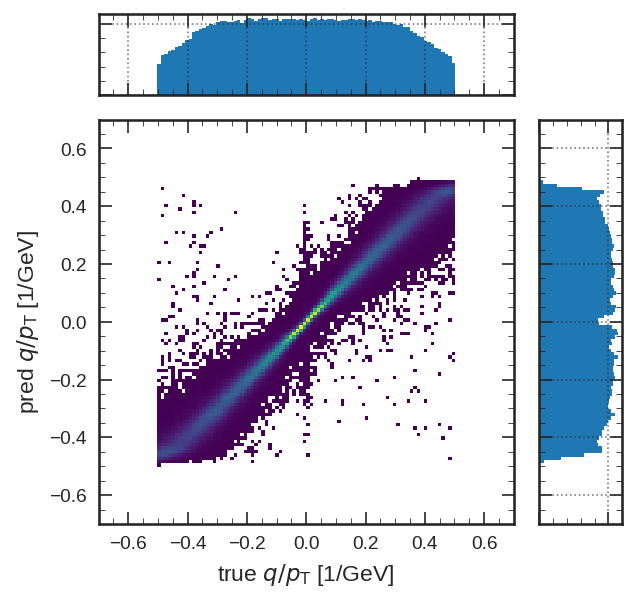

In [18]:
# Plot predictions
fig = plt.figure(figsize=(4.5, 4.5))

xx = np.squeeze(y_test_true)
yy = np.squeeze(y_test_pred)

gs = plt.GridSpec(2, 2, width_ratios=(5,1), height_ratios=(1,5), hspace=0.1, wspace=0.1)
ax = fig.add_subplot(gs[1,0])
ax_top = fig.add_subplot(gs[0,0], sharex=ax)
ax_right = fig.add_subplot(gs[1,1], sharey=ax)

ax.hist2d(xx, yy, bins=(120,120), range=((-0.7,0.7),(-0.7,0.7)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'pred $q/p_{\mathrm{T}}$ [1/GeV]')
ax_top.hist(xx, bins=120, range=(-0.7,0.7))
ax_top.tick_params(labelbottom=False, labelleft=False)
ax_right.hist(yy, bins=120, range=(-0.7,0.7), orientation='horizontal')
ax_right.tick_params(labelbottom=False, labelleft=False)

plt.show()

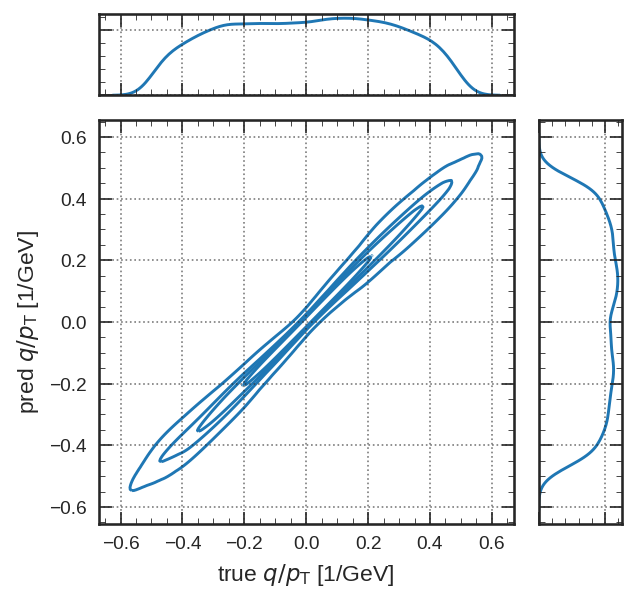

In [19]:
# Plot predictions
fig = plt.figure(figsize=(4.5, 4.5))

xx = np.squeeze(y_test_true_1)
yy = np.squeeze(y_test_pred_1)

gs = plt.GridSpec(2, 2, width_ratios=(5,1), height_ratios=(1,5), hspace=0.1, wspace=0.1)
ax = fig.add_subplot(gs[1,0])
ax_top = fig.add_subplot(gs[0,0], sharex=ax)
ax_right = fig.add_subplot(gs[1,1], sharey=ax)

df = pd.DataFrame({'x': xx, 'y': yy})
sns.kdeplot(data=df, x='x', y='y', levels=5, bw_adjust=1, ax=ax)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'pred $q/p_{\mathrm{T}}$ [1/GeV]')
sns.kdeplot(data=df, x='x', bw_adjust=1, ax=ax_top)
ax_top.set_xlabel('')
ax_top.set_ylabel('')
ax_top.tick_params(labelbottom=False, labelleft=False)
sns.kdeplot(data=df, y='y', bw_adjust=1, ax=ax_right)
ax_right.set_xlabel('')
ax_right.set_ylabel('')
ax_right.tick_params(labelbottom=False, labelleft=False)

plt.show()

[INFO    ] mu, sig, mse, mae, mad: -4.1827e-05, 0.0341, 0.0013, 0.0240, 0.0244
[INFO    ] gaus fit (a, mu, sig): 32463.97, -1.0371e-04, 0.0225
[INFO    ] mu, sig, mse, mae, mad: -2.8593e-05, 0.0150, 0.0005, 0.0112, 0.0103
[INFO    ] gaus fit (a, mu, sig): 4197.29, -1.3423e-04, 0.0094


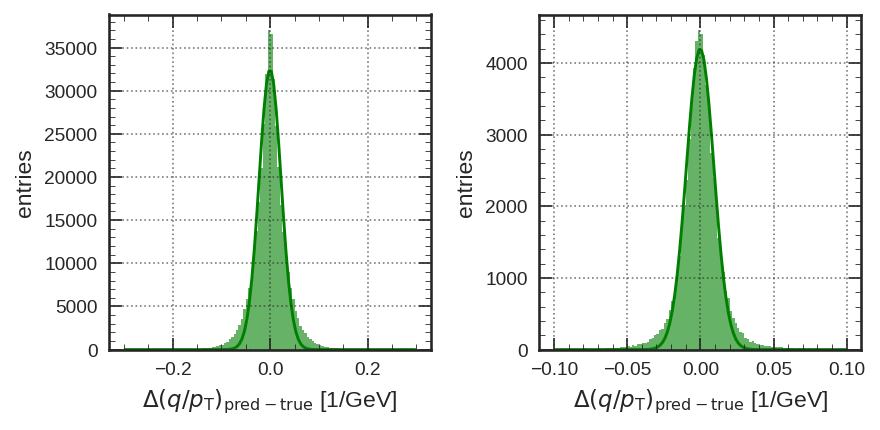

In [20]:
# Plot Delta(q/pt)
fig, axs = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True)

ya = np.squeeze(y_test_true)
yb = np.squeeze(y_test_pred)
yy = yb - ya
yy_core = yy[np.abs(yy) < 0.3]

ax = axs[0]
hist, edges, _ = ax.hist(yy, bins=120, range=(-0.3,0.3), histtype='stepfilled', color='g', alpha=0.6)
metrics = (yy_core.mean(), yy_core.std(),
           emtf_nbtools.mean_squared_error(ya, yb),
           emtf_nbtools.mean_absolute_error(ya, yb),
           emtf_nbtools.median_absolute_deviation(ya, yb))
popt = emtf_nbtools.fit_gaus(hist, edges, mu=metrics[0], sig=metrics[1])
xdata = (edges[1:] + edges[:-1]) / 2
ydata = emtf_nbtools.gaus(xdata, popt[0], popt[1], popt[2])
ax.plot(xdata, ydata, color='g')
ax.set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')
ax.set_ylabel(r'entries')
logger.info('mu, sig, mse, mae, mad: {0:.4e}, {1:.4f}, {2:.4f}, {3:.4f}, {4:.4f}'.format(*metrics))
logger.info('gaus fit (a, mu, sig): {0:.2f}, {1:.4e}, {2:.4f}'.format(*popt))

# Repeat with pt > 14 GeV
sel = np.squeeze(np.reciprocal(np.abs(y_test_true)) > 14.)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]
yy_core = yy[np.abs(yy) < 0.1]

ax = axs[1]
hist, edges, _ = ax.hist(yy, bins=120, range=(-0.1,0.1), histtype='stepfilled', color='g', alpha=0.6)
metrics = (yy_core.mean(), yy_core.std(),
           emtf_nbtools.mean_squared_error(ya, yb),
           emtf_nbtools.mean_absolute_error(ya, yb),
           emtf_nbtools.median_absolute_deviation(ya, yb))
popt = emtf_nbtools.fit_gaus(hist, edges, mu=metrics[0], sig=metrics[1])
xdata = (edges[1:] + edges[:-1]) / 2
ydata = emtf_nbtools.gaus(xdata, popt[0], popt[1], popt[2])
ax.plot(xdata, ydata, color='g')
ax.set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')
ax.set_ylabel(r'entries')
logger.info('mu, sig, mse, mae, mad: {0:.4e}, {1:.4f}, {2:.4f}, {3:.4f}, {4:.4f}'.format(*metrics))
logger.info('gaus fit (a, mu, sig): {0:.2f}, {1:.4e}, {2:.4f}'.format(*popt))

plt.show()

[INFO    ] mu, sig, mse, mae, mad: 3.2798e-04, 0.2088, 272.5009, 0.2660, 0.1368
[INFO    ] gaus fit (a, mu, sig): 39203.28, -9.0882e-03, 0.1244
[INFO    ] mu, sig, mse, mae, mad: -7.7424e-02, 0.3618, 1688.5239, 0.9837, 0.3059
[INFO    ] gaus fit (a, mu, sig): 3259.61, -1.0406e-01, 0.2265


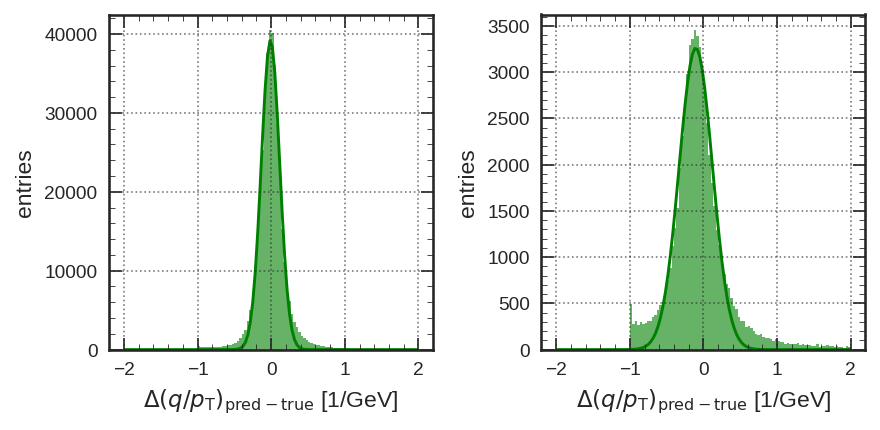

In [21]:
# Plot Delta(q/pt) / pt
fig, axs = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True)

ya = np.squeeze(np.abs(y_test_true / y_test_true))
yb = np.squeeze(np.abs(y_test_true / y_test_pred))
yy = yb - ya
yy_core = yy[np.abs(yy) < 1.5]

ax = axs[0]
hist, edges, _ = ax.hist(yy, bins=120, range=(-2,2), histtype='stepfilled', color='g', alpha=0.6)
metrics = (yy_core.mean(), yy_core.std(),
           emtf_nbtools.mean_squared_error(ya, yb),
           emtf_nbtools.mean_absolute_error(ya, yb),
           emtf_nbtools.median_absolute_deviation(ya, yb))
popt = emtf_nbtools.fit_gaus(hist, edges, mu=metrics[0], sig=metrics[1])
xdata = (edges[1:] + edges[:-1]) / 2
ydata = emtf_nbtools.gaus(xdata, popt[0], popt[1], popt[2])
ax.plot(xdata, ydata, color='g')
ax.set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')
ax.set_ylabel(r'entries')
logger.info('mu, sig, mse, mae, mad: {0:.4e}, {1:.4f}, {2:.4f}, {3:.4f}, {4:.4f}'.format(*metrics))
logger.info('gaus fit (a, mu, sig): {0:.2f}, {1:.4e}, {2:.4f}'.format(*popt))

# Repeat with pt > 14 GeV
sel = np.squeeze(np.reciprocal(np.abs(y_test_true)) > 14.)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]
yy_core = yy[np.abs(yy) < 1.5]

ax = axs[1]
hist, edges, _ = ax.hist(yy, bins=120, range=(-2,2), histtype='stepfilled', color='g', alpha=0.6)
metrics = (yy_core.mean(), yy_core.std(),
           emtf_nbtools.mean_squared_error(ya, yb),
           emtf_nbtools.mean_absolute_error(ya, yb),
           emtf_nbtools.median_absolute_deviation(ya, yb))
popt = emtf_nbtools.fit_gaus(hist, edges, mu=metrics[0], sig=metrics[1])
xdata = (edges[1:] + edges[:-1]) / 2
ydata = emtf_nbtools.gaus(xdata, popt[0], popt[1], popt[2])
ax.plot(xdata, ydata, color='g')
ax.set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')
ax.set_ylabel(r'entries')
logger.info('mu, sig, mse, mae, mad: {0:.4e}, {1:.4f}, {2:.4f}, {3:.4f}, {4:.4f}'.format(*metrics))
logger.info('gaus fit (a, mu, sig): {0:.2f}, {1:.4e}, {2:.4f}'.format(*popt))

plt.show()

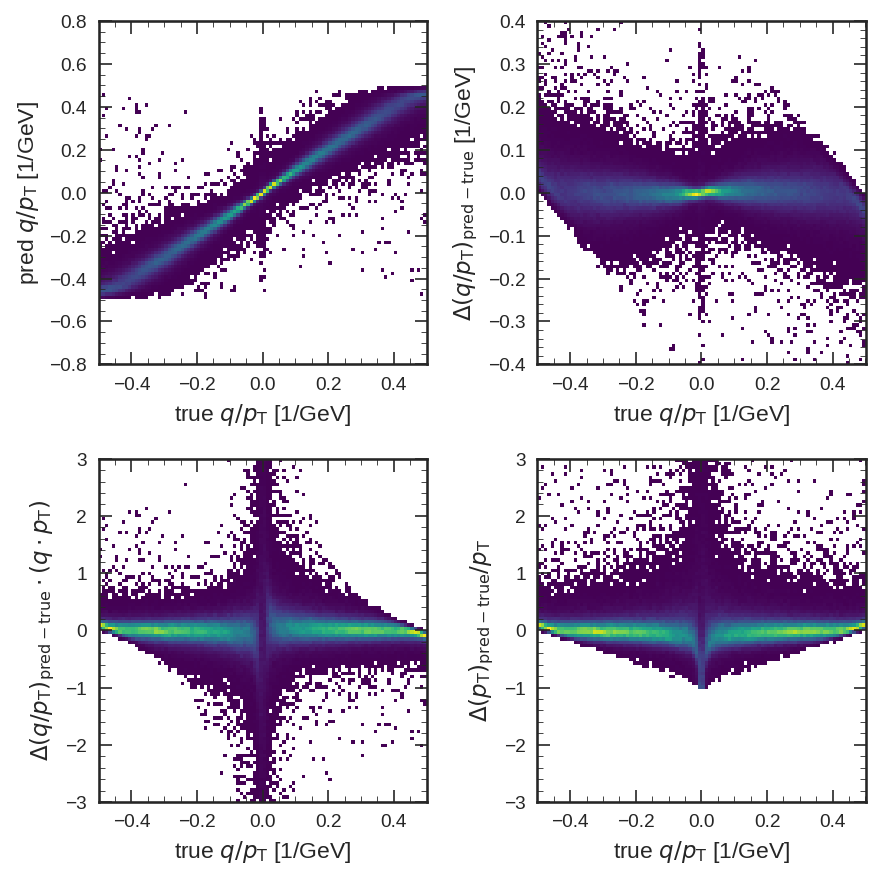

In [22]:
# Plot correlations
fig, axs = plt.subplots(2, 2, figsize=(6, 6), tight_layout=True)

xx = np.squeeze(y_test_true)
yy = np.squeeze(y_test_pred)
ax = axs[0,0]
ax.hist2d(xx, yy, bins=(100,100), range=((-0.5,0.5),(-0.8,0.8)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'pred $q/p_{\mathrm{T}}$ [1/GeV]')

yy = np.squeeze(y_test_pred - y_test_true)
ax = axs[0,1]
ax.hist2d(xx, yy, bins=(100,100), range=((-0.5,0.5),(-0.4,0.4)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')

with np.errstate(divide='ignore'):
  yy = np.squeeze((y_test_pred - y_test_true) / np.abs(y_test_true))
ax = axs[1,0]
ax.hist2d(xx, yy, bins=(100,100), range=((-0.5,0.5),(-3,3)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}} \cdot (q \cdot p_{\mathrm{T}})$')

with np.errstate(divide='ignore'):
  yy = np.squeeze(np.abs(y_test_true / y_test_pred) - 1)
ax = axs[1,1]
ax.hist2d(xx, yy, bins=(100,100), range=((-0.5,0.5),(-3,3)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{pred-true}} / p_{\mathrm{T}}$')

plt.show()

In [23]:
# Make better resolution plot
# resolution defined as Delta(pt) over pt (no charge), binned in 1/pt (also no charge)
xx = np.squeeze(np.abs(y_test_true))
yy = np.squeeze(np.abs(y_test_true/y_test_pred) - 1)

nbinsx = 100
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xx_pt = np.zeros(nbinsx, dtype=np.float32)
yy_mu = np.zeros(nbinsx, dtype=np.float32)
yy_sig = np.zeros(nbinsx, dtype=np.float32)
yy_tail = np.zeros(nbinsx, dtype=np.float32)
yy_cov = np.zeros(nbinsx, dtype=np.float32)

cache = {}

for i in range(nbinsx):
  xx_i = xx[inds==i]
  if len(xx_i) < 100:  # not enough stats
    continue

  pt = xx_i.mean()
  pt = 1.0 / pt

  yy_i = yy[inds==i]
  yy_i = yy_i[(-1.0 <= yy_i) & (yy_i <= 1.5)]
  mu, sig = yy_i.mean(), yy_i.std()
  assert np.abs(mu) < 1.0
  assert np.abs(sig) < 2.0

  hist, edges = np.histogram(yy_i, bins=160, range=(-2,2))
  xdata = (edges[1:] + edges[:-1]) / 2
  try:
    popt = emtf_nbtools.fit_gaus(hist, edges, mu=mu, sig=sig)
  except:
    popt = np.array([np.nan, np.nan, np.nan])
  #print(i, len(xx_i), mu, sig, pt, popt)

  ydata = emtf_nbtools.gaus(xdata, popt[0], popt[1], popt[2])
  tail = hist - ydata        # check non-gaussian high tail
  tail[tail < 0] = 0         # ignore hist < gaus
  tail[xdata < popt[2]] = 0  # ignore low tail
  tail = tail.sum() / len(xx_i)

  pct = np.percentile(yy_i, (100 - 90), overwrite_input=True)  # find 10-percentile
  cov = -1 * pct / popt[2]
  # If truly gaussian, the required number of sigmas is 1.28155 for 90% coverage
  #print(scipy.special.erfinv(0.80) * np.sqrt(2))

  xx_pt[i] = pt
  yy_mu[i] = popt[1]
  yy_sig[i] = popt[2]
  yy_tail[i] = tail
  yy_cov[i] = cov

  if 14. < pt < 15.:
    cache[0] = (i, xx_i, yy_i)
  elif 20. < pt < 22.:
    cache[1] = (i, xx_i, yy_i)
  elif 25. < pt < 28.:
    cache[2] = (i, xx_i, yy_i)
  elif 28. < pt < 33.:
    cache[3] = (i, xx_i, yy_i)

[INFO    ] gaus fit (a, mu, sig): 245.62, -6.6921e-02, 0.1749
[INFO    ] gaus fit (a, mu, sig): 230.53, -7.4535e-02, 0.1818
[INFO    ] gaus fit (a, mu, sig): 212.64, -9.2001e-02, 0.1902
[INFO    ] gaus fit (a, mu, sig): 200.77, -1.1319e-01, 0.2001


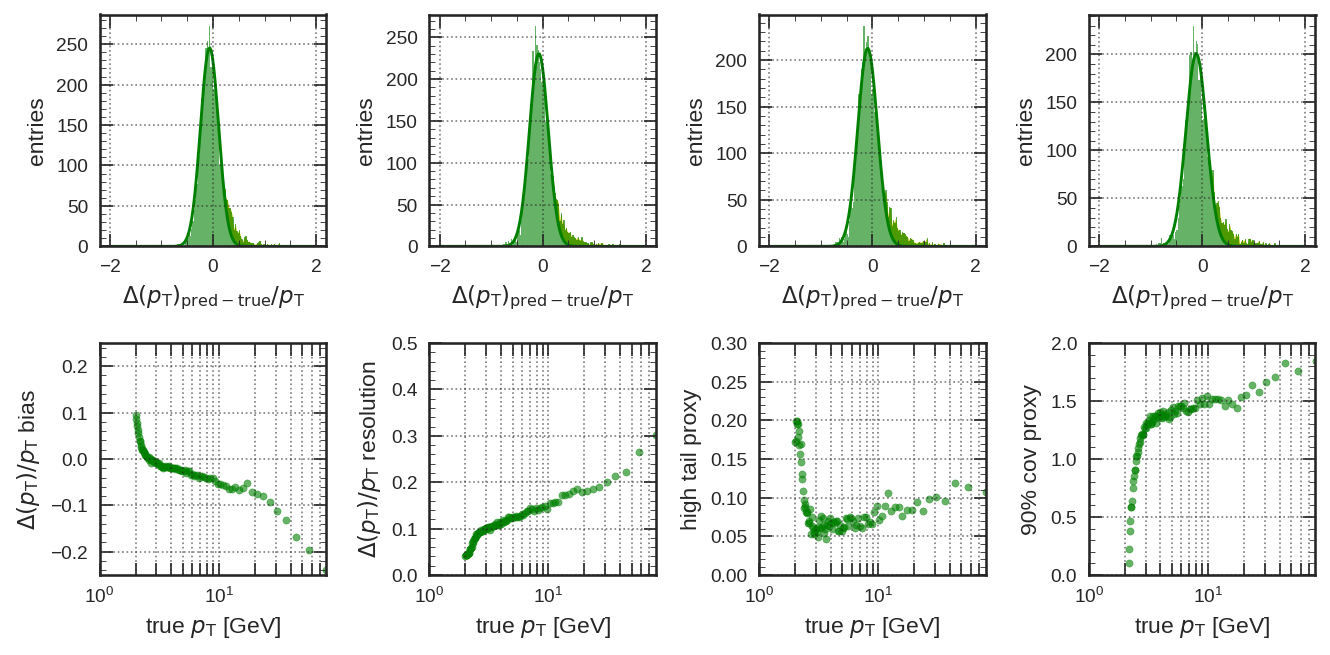

In [24]:
# Make better resolution plot
fig, axs = plt.subplots(2, 4, figsize=(9, 9/2), tight_layout=True)

for i in range(4):
  ax = axs[0,i]
  (ii, xx_i, yy_i) = cache[i]  # read from cache
  hist, edges, _ = ax.hist(yy_i, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
  popt = emtf_nbtools.fit_gaus(hist, edges, mu=yy_mu[ii], sig=yy_mu[ii])
  xdata = (edges[1:] + edges[:-1])/2
  ydata = emtf_nbtools.gaus(xdata, popt[0], popt[1], popt[2])
  tail = hist - ydata        # check non-gaussian high tail
  tail[tail < 0] = 0         # ignore hist < gaus
  tail[xdata < popt[2]] = 0  # ignore low tail
  ax.plot(xdata, ydata, color='g')
  ax.fill_between(xdata, ydata, ydata + tail, facecolor='y')
  ax.set_xlabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{pred-true}} / p_{\mathrm{T}}$')
  ax.set_ylabel(r'entries')
  logger.info('gaus fit (a, mu, sig): {0:.2f}, {1:.4e}, {2:.4f}'.format(*popt))

ax = axs[1,0]
ax.scatter(xx_pt, yy_mu, s=12, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(-0.25,0.25)
ax.set_xscale('log')
ax.set_xticks(list(range(1,10)) + list(range(10,80,10)))
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'$\Delta(p_{\mathrm{T}}) / p_{\mathrm{T}}$ bias')

ax = axs[1,1]
ax.scatter(xx_pt, yy_sig, s=12, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,0.5)
ax.set_xscale('log')
ax.set_xticks(list(range(1,10)) + list(range(10,80,10)))
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'$\Delta(p_{\mathrm{T}}) / p_{\mathrm{T}}$ resolution')

ax = axs[1,2]
ax.scatter(xx_pt, yy_tail, s=12, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,0.3)
ax.set_xscale('log')
ax.set_xticks(list(range(1,10)) + list(range(10,80,10)))
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'high tail proxy')

ax = axs[1,3]
ax.scatter(xx_pt, yy_cov, s=12, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,2)
ax.set_xscale('log')
ax.set_xticks(list(range(1,10)) + list(range(10,80,10)))
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'90% cov proxy')

plt.show()

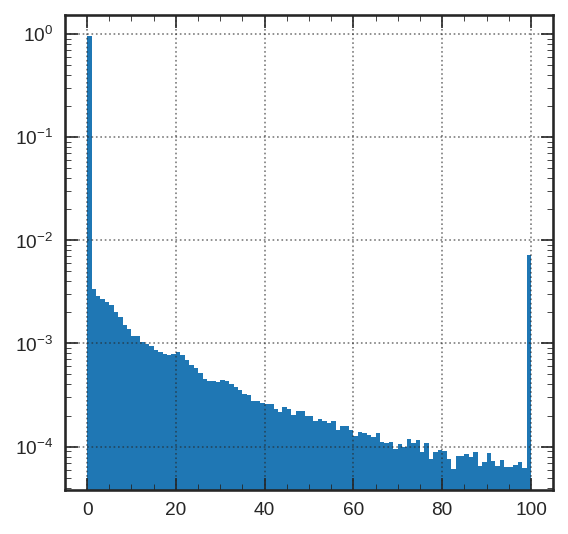

[INFO    ] regularization_pt_output: 81522/1407704 = 0.05791


In [25]:
# Check regularization loss
def regularization_pt_output():
  regularization = model.get_layer('regularization')
  x = regularization.loss_fn._data
  y = regularization.loss_fn._model(x, training=False)
  l1, bias = regularization.l1, regularization.bias
  clip_value_min, clip_value_max = 0., 100.
  y_as_pt = tf.math.reciprocal_no_nan(tf.math.abs(y))
  new_y_as_pt = tf.clip_by_value(y_as_pt - bias, clip_value_min, clip_value_max)
  return np.squeeze(new_y_as_pt.numpy())

fig, ax = plt.subplots()
yy = regularization_pt_output()
ax.hist(yy, bins=100, range=(0,100), density=True)
ax.set_yscale('log')
plt.show()

logger.info('regularization_pt_output: {}/{} = {:.5f}'.format(
    np.count_nonzero(yy), yy.shape[0], np.count_nonzero(yy) / yy.shape[0]))

### Calibrate pt

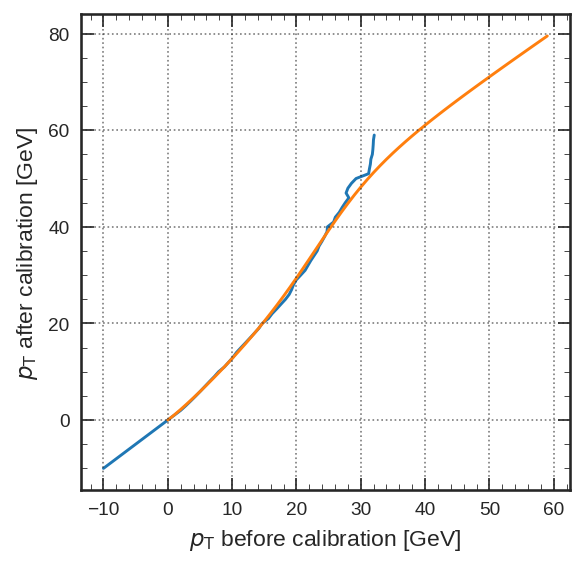

[INFO    ] [ 0.000,  1.000,  2.000,  2.826,  3.605,  4.358,  5.091,  5.797,  6.506,
  7.240,  7.900,  8.803,  9.477, 10.151, 10.682, 11.380, 12.092, 12.790,
 13.483, 14.169, 14.660, 15.638, 16.205, 16.922, 17.604, 18.299, 18.871,
 19.249, 19.537, 19.963, 20.664, 21.352, 21.788, 22.228, 22.726, 23.222,
 23.512, 23.969, 24.384, 24.756, 24.826, 25.783, 26.046, 26.664, 27.101,
 27.596, 28.154, 27.718, 28.004, 28.548, 29.267, 31.223, 31.348, 31.498,
 31.573, 31.803, 31.883, 31.938, 31.977, 32.098]
[INFO    ] [ 0.000,  1.050,  2.194,  3.386,  4.620,  5.891,  7.197,  8.536,  9.904,
 11.303, 12.732, 14.194, 15.692, 17.229, 18.810, 20.439, 22.122, 23.860,
 25.655, 27.505, 29.406, 31.349, 33.322, 35.310, 37.296, 39.260, 41.184,
 43.053, 44.853, 46.575, 48.215, 49.773, 51.251, 52.656, 53.995, 55.274,
 56.503, 57.688, 58.834, 59.949, 61.036, 62.100, 63.144, 64.171, 65.183,
 66.183, 67.173, 68.153, 69.125, 70.091, 71.050, 72.004, 72.954, 73.899,
 74.841, 75.780, 76.716, 77.649, 78.580, 79.510]
[INF

In [26]:
# Calibrate pt
from scipy.interpolate import Rbf

def monotonically_increasing(a):
  return np.all(a[1:] >= a[:-1], axis=-1)

pt_true = np.squeeze(np.reciprocal(np.abs(y_test_true)))
pt_pred = np.squeeze(np.reciprocal(np.abs(y_test_pred)))
pt_pred = np.clip(pt_pred, 0., 7000.)

coverage = 90.  # nominal coverage
coverage += 1.5  # additional coverage due to fiducial cuts
xmin, xmax, nbinsx = 0., 60., 60
edges = np.linspace(xmin, xmax, num=(nbinsx + 1), dtype=np.float32)

# Map pt -> pt bin
calib_indices = emtf_nbtools.hist_digitize_inclusive(pt_true, edges)
# Map pt bin -> 90% coverage threshold
calib_data = np.zeros(nbinsx, dtype=np.float32)

for i, edge in enumerate(edges[:-1]):
  # Skip 2 GeV and below
  if edge <= 2:
    calib_data[i] = edge
    continue

  # Customize step size
  # 1, 2, 4, 6, 8 or 10 GeV
  if edge <= 10:
    step = 1
  elif edge <= 20:
    step = 2
  elif edge <= 30:
    step = 4
  elif edge <= 40:
    step = 6
  elif edge <= 50:
    step = 8
  else:
    step = 10

  sel = (i <= calib_indices) & (calib_indices <= (i + step - 1))
  selected = pt_pred[sel]
  thres = np.percentile(selected, 100. - coverage, overwrite_input=True)
  calib_data[i] = thres


# Extend edges into negative x
edges_neg_x = np.linspace(-10, -1, num=10, dtype=np.float32)
xdata = np.concatenate((edges_neg_x, calib_data))
ydata = np.concatenate((edges_neg_x, edges[:-1]))
# Fit with Rbf
# These parameters require some tuning
rbfi = Rbf(xdata[:-10], ydata[:-10], epsilon=10., smooth=1., function='multiquadric')
last_binx = 30  # truncate at 30 GeV

# Plot
fig, ax = plt.subplots()
ax.plot(xdata, ydata)
xdata = edges[:-1]
ydata = rbfi(xdata).astype(np.float32)
ydata[0] = 0.  # force to start with 0
ax.plot(xdata, ydata)
ax.set_xlabel(r'$p_{\mathrm{T}}$ before calibration [GeV]')
ax.set_ylabel(r'$p_{\mathrm{T}}$ after calibration [GeV]')
plt.show()

with np.errstate(divide='ignore', invalid='ignore'):
  zdata = ydata / xdata

logger.info(np.array2string(calib_data, separator=', ', precision=3, floatmode='fixed'))
logger.info(np.array2string(ydata, separator=', ', precision=3, floatmode='fixed'))
logger.info(np.array2string(zdata, separator=', ', precision=3, floatmode='fixed'))
assert monotonically_increasing(zdata[1:last_binx])

In [27]:
def find_emtf_pt_initializer():
  lut = ydata.copy()

  def lookup(x):
    x = np.asarray(x, dtype=np.float32)
    bin_size = (xmax - xmin) / nbinsx
    binx = np.floor((x - xmin) / bin_size).astype(np.int32)
    binx_mask = binx < last_binx
    binx_safe = np.where(binx_mask, binx, last_binx)
    x0, x1 = binx_safe * bin_size, (binx_safe + 1) * bin_size
    y0, y1 = lut[binx_safe], lut[binx_safe + 1]
    y = (x - x0) / (x1 - x0) * (y1 - y0) + y0  # interpolate
    y_lin = x / x0 * y0  # extrapolate
    return np.where(binx_mask, y, y_lin)
  return lookup


# The initializer will instantiate the lookup table
find_emtf_pt = find_emtf_pt_initializer()

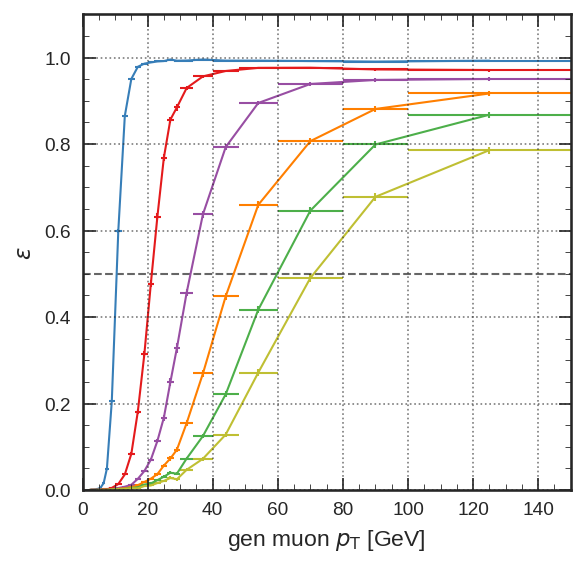

[INFO    ] eff @10/20/30/40/50/60 GeV: 59.94%, 47.73%, 45.65%, 44.81%, 41.70%, 49.03%


In [28]:
# Efficiency vs pt
eff_pt_bins = (0., 0.5, 1., 1.5, 2., 3., 4., 5., 6., 7., 8., 10., 12., 14., 16., 18., 20.,
               22., 24., 26., 28., 30., 34., 40., 48., 60., 80., 100., 150.)
pt_list = (10., 20., 30., 40., 50., 60.)
pt_palette = ('#377eb8', '#e41a1c', '#984ea3', '#ff7f00', '#4daf4a', '#bfbf33', '#a65628', '#f781bf')

denom_hists = []
num_hists = []
eff_hists = []

# Create histograms
for pt in pt_list:
  pt_passed = (pt_pred > pt)
  denom_hist, edges = np.histogram(pt_true, bins=eff_pt_bins)
  num_hist, edges = np.histogram(pt_true[pt_passed], bins=eff_pt_bins)
  with np.errstate(divide='ignore', invalid='ignore'):
    eff_hist = np.true_divide(num_hist, denom_hist)
  denom_hists.append(denom_hist)
  num_hists.append(num_hist)
  eff_hists.append(eff_hist)


# Plot
fig, ax = plt.subplots()

for denom_hist, num_hist, eff_hist, color in zip(denom_hists, num_hists, eff_hists, pt_palette):
  xdata = (edges[1:] + edges[:-1]) / 2
  xerr = (edges[1:] - edges[:-1]) / 2
  yerr = emtf_nbtools.find_efficiency_errors(denom_hist, num_hist)
  ydata = eff_hist
  ax.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)

ax.axhline(0.5, ls='dashed', lw=1, color='k', alpha=0.6)
ax.set_xlim(0, edges[-1])
ax.set_ylim(0, 1.1)
ax.set_xlabel(r'gen muon $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'$\varepsilon$')
plt.show()

logger.info("eff @10/20/30/40/50/60 GeV: {:.2%}, {:.2%}, {:.2%}, {:.2%}, {:.2%}, {:.2%}".format(
    eff_hists[0][11], eff_hists[1][16], eff_hists[2][21], eff_hists[3][23], eff_hists[4][24],
    eff_hists[5][25]))

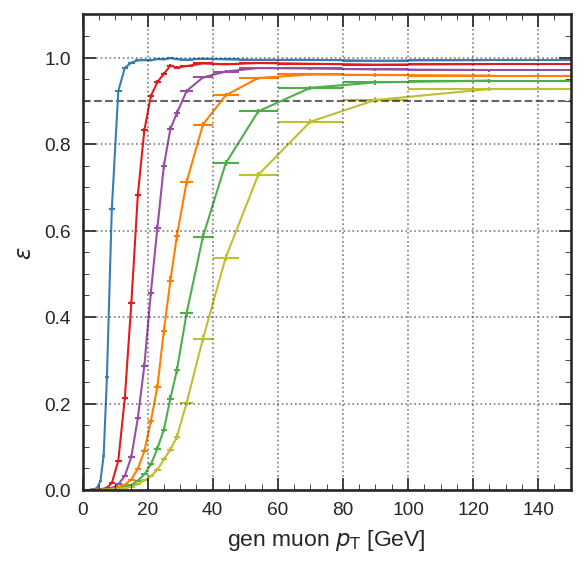

[INFO    ] eff @10/20/30/40/50/60 GeV: 92.29%, 91.10%, 92.29%, 91.28%, 87.57%, 85.17%


In [29]:
# Efficiency vs pt (after calibration)
pt_pred_calib = find_emtf_pt(pt_pred)

denom_hists = []
num_hists = []
eff_hists = []

# Create histograms
for pt in pt_list:
  pt_passed = (pt_pred_calib > pt)
  denom_hist, edges = np.histogram(pt_true, bins=eff_pt_bins)
  num_hist, edges = np.histogram(pt_true[pt_passed], bins=eff_pt_bins)
  with np.errstate(divide='ignore', invalid='ignore'):
    eff_hist = np.true_divide(num_hist, denom_hist)
  denom_hists.append(denom_hist)
  num_hists.append(num_hist)
  eff_hists.append(eff_hist)


# Plot
fig, ax = plt.subplots()

for denom_hist, num_hist, eff_hist, color in zip(denom_hists, num_hists, eff_hists, pt_palette):
  xdata = (edges[1:] + edges[:-1]) / 2
  xerr = (edges[1:] - edges[:-1]) / 2
  yerr = emtf_nbtools.find_efficiency_errors(denom_hist, num_hist)
  ydata = eff_hist
  ax.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)

ax.axhline(0.9, ls='dashed', lw=1, color='k', alpha=0.6)
ax.set_xlim(0, edges[-1])
ax.set_ylim(0, 1.1)
ax.set_xlabel(r'gen muon $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'$\varepsilon$')
plt.show()

logger.info("eff @10/20/30/40/50/60 GeV: {:.2%}, {:.2%}, {:.2%}, {:.2%}, {:.2%}, {:.2%}".format(
    eff_hists[0][11], eff_hists[1][16], eff_hists[2][21], eff_hists[3][23], eff_hists[4][24],
    eff_hists[5][25]))

### Inspect weights

In [30]:
# Make ridgeplot
def min_max(x):
  return (np.min(x), np.max(x))

def ridgeplot():
  n = xx.shape[1]
  fig, axs = plt.subplots(n, 1, figsize=(6, n/4), sharex=True, sharey=False,
                          gridspec_kw=dict(hspace=-0.5))
  pal = sns.cubehelix_palette(n, rot=-.4, light=.7)

  for i in range(n):
    if n == 1:
      ax = axs
    else:
      ax = axs[(n - 1) - i]
    limit = 4
    sns.kdeplot(np.clip(xx[:, i], -limit, limit), bw_adjust=0.25, clip_on=False,
                fill=True, alpha=1, color=pal[i], ax=ax)
    sns.kdeplot(np.clip(xx[:, i], -limit, limit), bw_adjust=0.25, clip_on=False,
                lw=1.0, color='w', ax=ax)

    # Remove borders, axis ticks, labels, and make background transparent
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                   labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    if i == 0:
      ax.tick_params(axis='x', which='both', bottom=True, labelbottom=True)
    spines = ['top', 'right', 'left', 'bottom']
    for s in spines:
      if s != 'bottom':
        ax.spines[s].set_visible(False)
    ax.patch.set_alpha(0)

    # Label
    ax.text(0, 0.2, str(i), fontsize=8, ha='right', va='center', transform=ax.transAxes)

  logger.info('(min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))

  plt.show()

In [31]:
# Inspect intermediate layers
if not do_quantization:
  extractor_layers = [model.get_layer('preprocessing').output,
                      model.get_layer('dense').output,
                      model.get_layer('batch_normalization').output,
                      model.get_layer('activation').output,
                      model.get_layer('dense_1').output,
                      model.get_layer('batch_normalization_1').output,
                      model.get_layer('activation_1').output,
                      model.get_layer('dense_2').output,
                      model.get_layer('batch_normalization_2').output,
                      model.get_layer('activation_2').output,
                      model.get_layer('dense_final').output,]

  extractor = tf.keras.Model(inputs=model.inputs, outputs=extractor_layers)

  extracted = extractor(x_test_1, training=False)
  extracted = iter(extracted)
  extracted_preprocessing = next(extracted).numpy()
  extracted_dense = next(extracted).numpy()
  extracted_batch_normalization = next(extracted).numpy()
  extracted_activation = next(extracted).numpy()
  extracted_dense_1 = next(extracted).numpy()
  extracted_batch_normalization_1 = next(extracted).numpy()
  extracted_activation_1 = next(extracted).numpy()
  extracted_dense_2 = next(extracted).numpy()
  extracted_batch_normalization_2 = next(extracted).numpy()
  extracted_activation_2 = next(extracted).numpy()
  extracted_dense_final = next(extracted).numpy()

/blue/avery/jlow/L1MuonTrigger/scratch/2020-00-00-work/miniconda/envs/tf/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/blue/avery/jlow/L1MuonTrigger/scratch/2020-00-00-work/miniconda/envs/tf/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
[INFO    ] (min, max): -6.5469, 6.9111


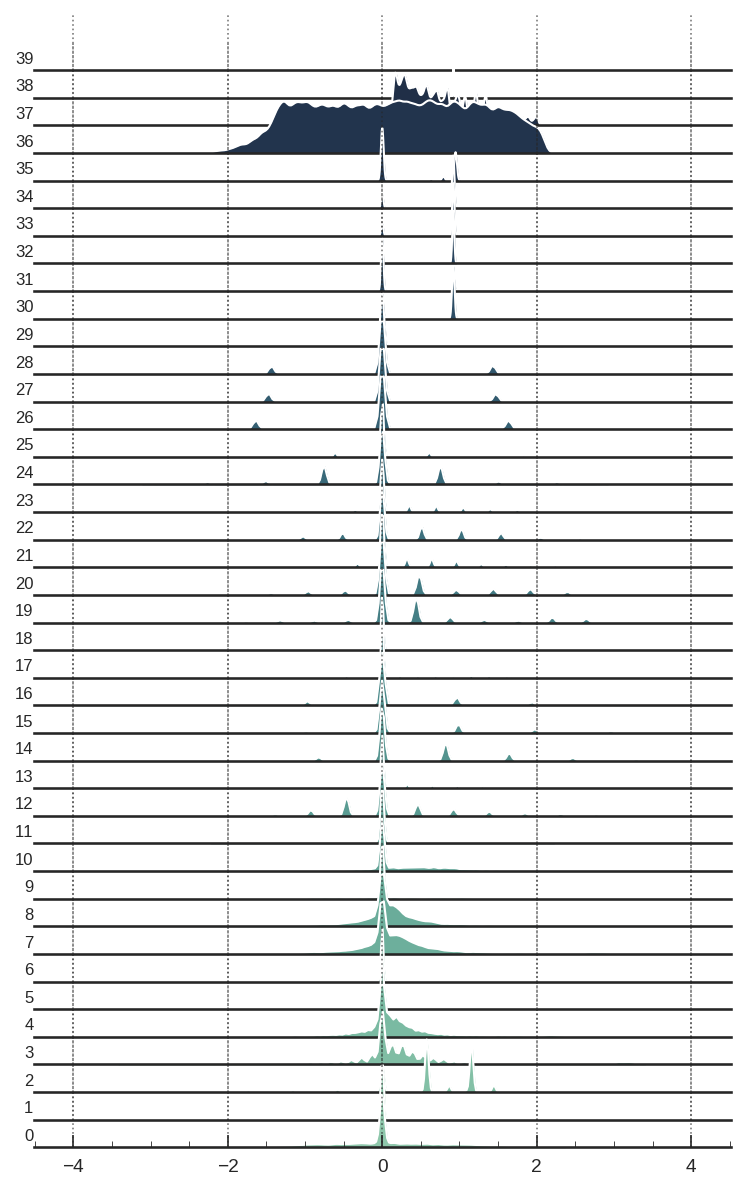

[INFO    ] (min, max): -13.3963, 15.7564


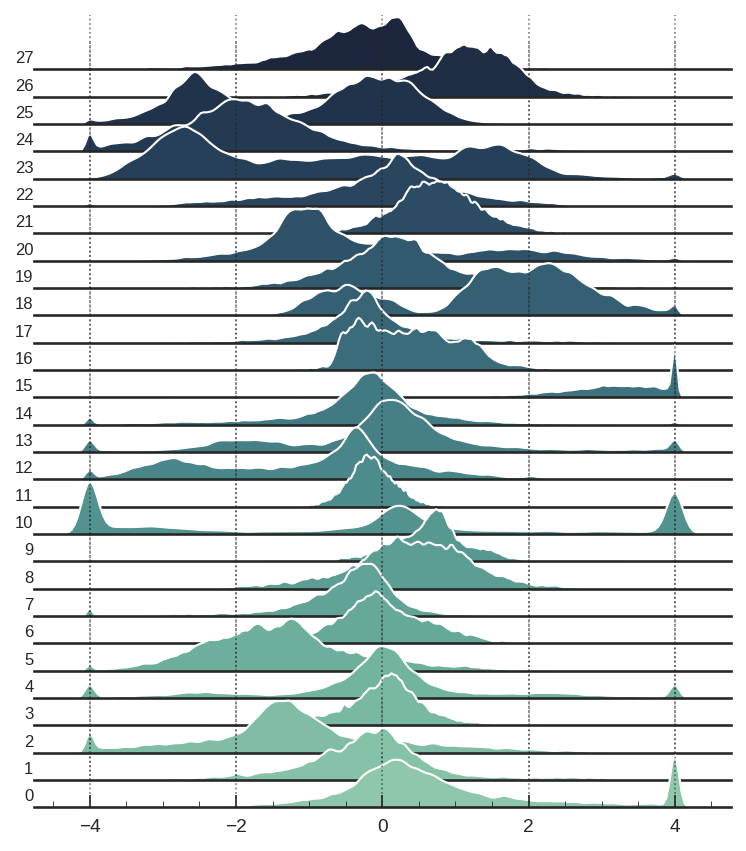

[INFO    ] (min, max): -1.0000, 1.0000


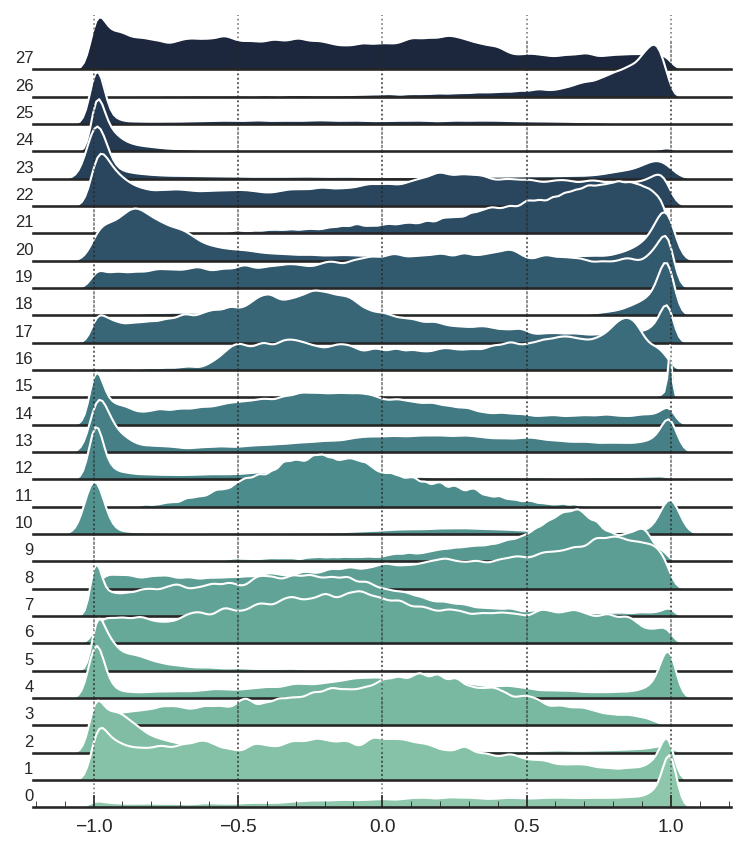

[INFO    ] (min, max): -11.3771, 9.8648


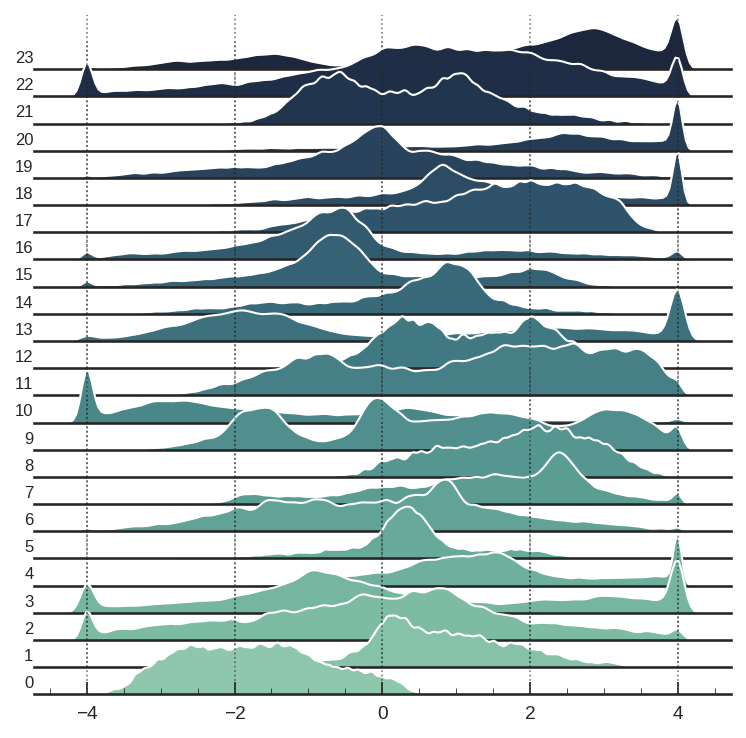

[INFO    ] (min, max): -1.0000, 1.0000


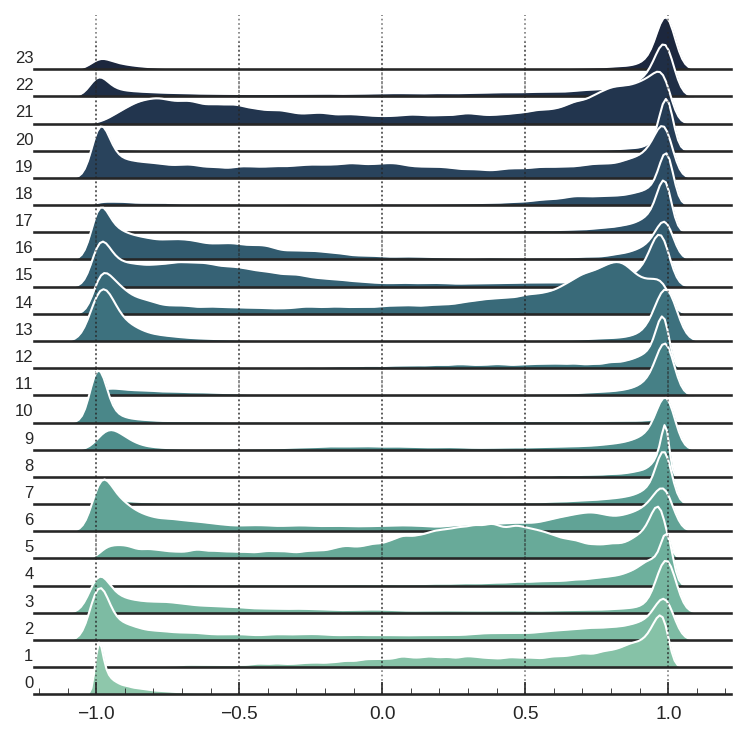

[INFO    ] (min, max): -13.7833, 13.3325


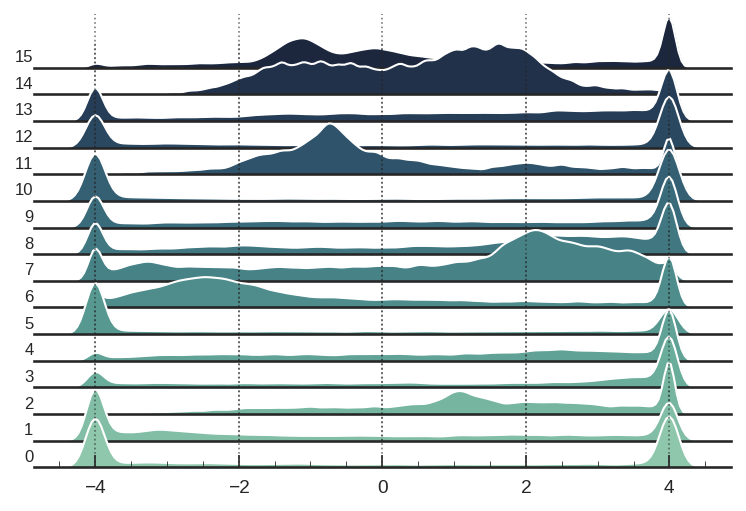

[INFO    ] (min, max): -1.0000, 1.0000


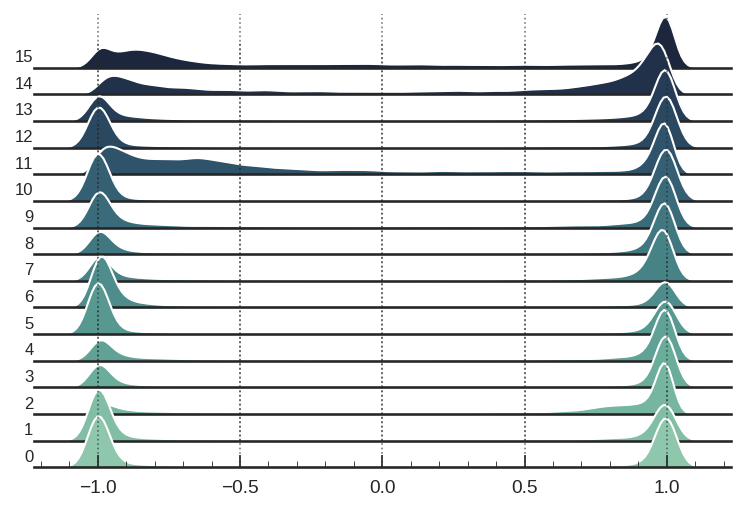

[INFO    ] (min, max): -0.4861, 0.4873


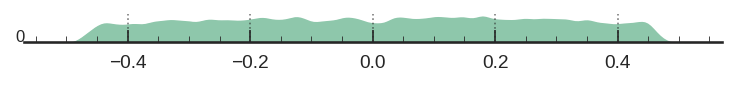

In [32]:
if not do_quantization:
  xx = extracted_preprocessing
  ridgeplot()
  xx = extracted_batch_normalization
  ridgeplot()
  xx = extracted_activation
  ridgeplot()
  xx = extracted_batch_normalization_1
  ridgeplot()
  xx = extracted_activation_1
  ridgeplot()
  xx = extracted_batch_normalization_2
  ridgeplot()
  xx = extracted_activation_2
  ridgeplot()
  xx = extracted_dense_final
  ridgeplot()

[INFO    ] preprocessing (min, max): 0.0000, 0.9873
[INFO    ] batch_normalization (min, max): 0.0537, 1.0761
[INFO    ] batch_normalization_1 (min, max): 0.3415, 1.4028
[INFO    ] batch_normalization_2 (min, max): 0.8136, 1.6998
[INFO    ] preprocessing (min, max): 0.0000, 0.0000
[INFO    ] batch_normalization (min, max): -2.8997, 4.3446
[INFO    ] batch_normalization_1 (min, max): -2.6844, 4.0996
[INFO    ] batch_normalization_2 (min, max): -4.1631, 1.9623
[INFO    ] dense (min, max): -4.7391, 2.8336
[INFO    ] dense_1 (min, max): -2.8130, 2.9654
[INFO    ] dense_2 (min, max): -3.1665, 3.5904
[INFO    ] dense_final (min, max): -2.2309, 2.6776


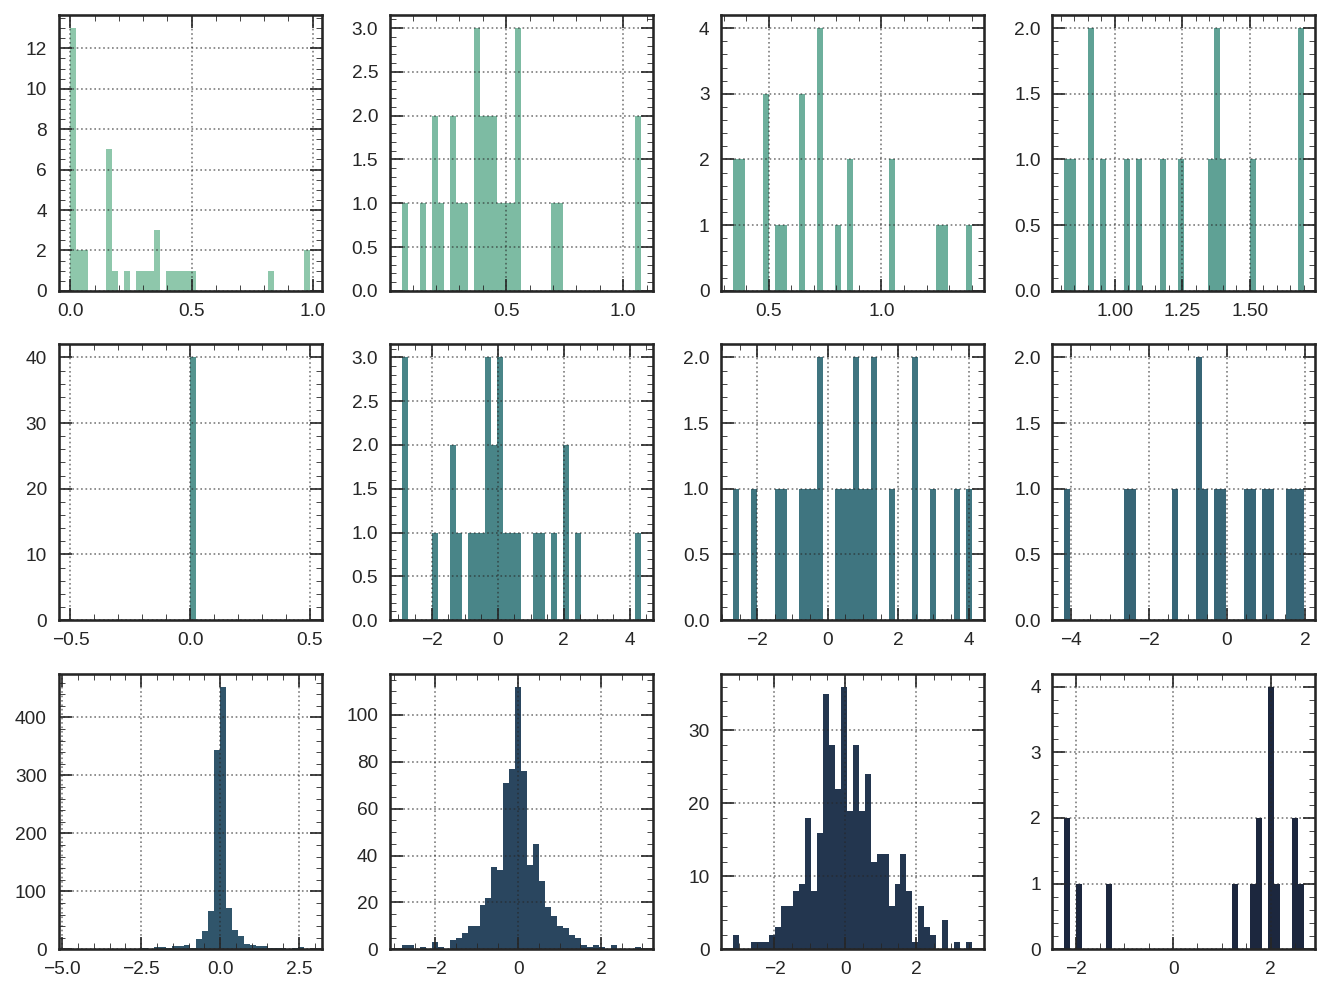

In [33]:
# Inspect model weights
if not do_quantization:
  assert len(model.get_layer('preprocessing').weights) == 2
  assert len(model.get_layer('batch_normalization').weights) == 4
  assert len(model.get_layer('batch_normalization_1').weights) == 4
  assert len(model.get_layer('batch_normalization_2').weights) == 4
  assert len(model.get_layer('dense').weights) == 1
  assert len(model.get_layer('dense_1').weights) == 1
  assert len(model.get_layer('dense_2').weights) == 1
  assert len(model.get_layer('dense_final').weights) == 1

  def get_normalization_scale_and_offset(layer):
    scale = layer.scale.numpy()
    offset = layer.offset.numpy()
    return (scale, offset)

  def get_batchnorm_scale_and_offset(layer):
    scale = (layer.gamma / tf.sqrt(layer.moving_variance)).numpy()
    offset = (layer.beta - layer.moving_mean * (layer.gamma / tf.sqrt(layer.moving_variance))).numpy()
    return (scale, offset)

  def get_folded_kernel_scale_and_offset(kernel, layer):
    scale = (kernel * (layer.gamma / tf.sqrt(layer.moving_variance))).numpy()
    offset = (layer.beta - layer.moving_mean * (layer.gamma / tf.sqrt(layer.moving_variance))).numpy()
    return (scale, offset)

  fig, axs = plt.subplots(3, 4, figsize=(9, 9/4*3), tight_layout=True)
  pal = sns.cubehelix_palette(12, rot=-.4, light=.7)

  xx = get_normalization_scale_and_offset(model.get_layer('preprocessing'))[0]
  ax = axs[0,0]
  ax.hist(xx, bins=40, color=pal[0])
  logger.info('preprocessing (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('batch_normalization'))[0]
  ax = axs[0,1]
  ax.hist(xx, bins=40, color=pal[1])
  logger.info('batch_normalization (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('batch_normalization_1'))[0]
  ax = axs[0,2]
  ax.hist(xx, bins=40, color=pal[2])
  logger.info('batch_normalization_1 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('batch_normalization_2'))[0]
  ax = axs[0,3]
  ax.hist(xx, bins=40, color=pal[3])
  logger.info('batch_normalization_2 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))

  xx = get_normalization_scale_and_offset(model.get_layer('preprocessing'))[1]
  ax = axs[1,0]
  ax.hist(xx, bins=40, color=pal[4])
  logger.info('preprocessing (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('batch_normalization'))[1]
  ax = axs[1,1]
  ax.hist(xx, bins=40, color=pal[5])
  logger.info('batch_normalization (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('batch_normalization_1'))[1]
  ax = axs[1,2]
  ax.hist(xx, bins=40, color=pal[6])
  logger.info('batch_normalization_1 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('batch_normalization_2'))[1]
  ax = axs[1,3]
  ax.hist(xx, bins=40, color=pal[7])
  logger.info('batch_normalization_2 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))

  xx = get_folded_kernel_scale_and_offset(model.get_layer('dense').kernel.numpy(),
                                          model.get_layer('batch_normalization'))[0]
  ax = axs[2,0]
  ax.hist(xx.reshape(-1), bins=40, color=pal[8])
  logger.info('dense (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_folded_kernel_scale_and_offset(model.get_layer('dense_1').kernel.numpy(),
                                          model.get_layer('batch_normalization_1'))[0]
  ax = axs[2,1]
  ax.hist(xx.reshape(-1), bins=40, color=pal[9])
  logger.info('dense_1 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_folded_kernel_scale_and_offset(model.get_layer('dense_2').kernel.numpy(),
                                          model.get_layer('batch_normalization_2'))[0]
  ax = axs[2,2]
  ax.hist(xx.reshape(-1), bins=40, color=pal[10])
  logger.info('dense_2 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = model.get_layer('dense_final').kernel.numpy()
  ax = axs[2,3]
  ax.hist(xx.reshape(-1), bins=40, color=pal[11])
  logger.info('dense_final (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))

  plt.show()

In [34]:
# Inspect intermediate layers
if do_quantization:
  extractor_layers = [model.get_layer('quant_preprocessing').output,
                      model.get_layer('quant_dense').output,
                      model.get_layer('quant_activation').output,
                      model.get_layer('quant_dense_1').output,
                      model.get_layer('quant_activation_1').output,
                      model.get_layer('quant_dense_2').output,
                      model.get_layer('quant_activation_2').output,
                      model.get_layer('quant_dense_final').output,]

  extractor = tf.keras.Model(inputs=model.inputs, outputs=extractor_layers)

  extracted = extractor(x_test_1, training=False)
  extracted = iter(extracted)
  extracted_preprocessing = next(extracted).numpy()
  extracted_dense = next(extracted).numpy()
  extracted_activation = next(extracted).numpy()
  extracted_dense_1 = next(extracted).numpy()
  extracted_activation_1 = next(extracted).numpy()
  extracted_dense_2 = next(extracted).numpy()
  extracted_activation_2 = next(extracted).numpy()
  extracted_dense_final = next(extracted).numpy()

In [35]:
if do_quantization:
  xx = extracted_preprocessing
  ridgeplot()
  xx = extracted_dense
  ridgeplot()
  xx = extracted_activation
  ridgeplot()
  xx = extracted_dense_1
  ridgeplot()
  xx = extracted_activation_1
  ridgeplot()
  xx = extracted_dense_2
  ridgeplot()
  xx = extracted_activation_2
  ridgeplot()
  xx = extracted_dense_final
  ridgeplot()

In [36]:
# Inspect model weights
if do_quantization:
  def get_normalization_scale_and_offset(layer):
    scale = layer.scale.numpy()
    offset = layer.offset.numpy()
    return (scale, offset)

  def get_batchnorm_scale_and_offset(layer):
    scale = (layer.gamma / tf.sqrt(layer.moving_variance)).numpy()
    offset = (layer.beta - layer.moving_mean * (layer.gamma / tf.sqrt(layer.moving_variance))).numpy()
    return (scale, offset)

  def get_folded_kernel_scale_and_offset(kernel, layer):
    scale = (kernel * (layer.gamma / tf.sqrt(layer.moving_variance))).numpy()
    offset = (layer.beta - layer.moving_mean * (layer.gamma / tf.sqrt(layer.moving_variance))).numpy()
    return (scale, offset)

  fig, axs = plt.subplots(3, 4, figsize=(9, 9/4*3), tight_layout=True)
  pal = sns.cubehelix_palette(12, rot=-.4, light=.7)

  xx = get_normalization_scale_and_offset(model.get_layer('quant_preprocessing').layer)[0]
  ax = axs[0,0]
  ax.hist(xx, bins=40, color=pal[0])
  logger.info('preprocessing (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('quant_dense').layer.batchnorm)[0]
  ax = axs[0,1]
  ax.hist(xx, bins=40, color=pal[1])
  logger.info('batch_normalization (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('quant_dense_1').layer.batchnorm)[0]
  ax = axs[0,2]
  ax.hist(xx, bins=40, color=pal[2])
  logger.info('batch_normalization_1 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('quant_dense_2').layer.batchnorm)[0]
  ax = axs[0,3]
  ax.hist(xx, bins=40, color=pal[3])
  logger.info('batch_normalization_2 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))

  xx = get_normalization_scale_and_offset(model.get_layer('quant_preprocessing').layer)[1]
  ax = axs[1,0]
  ax.hist(xx, bins=40, color=pal[4])
  logger.info('preprocessing (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('quant_dense').layer.batchnorm)[1]
  ax = axs[1,1]
  ax.hist(xx, bins=40, color=pal[5])
  logger.info('batch_normalization (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('quant_dense_1').layer.batchnorm)[1]
  ax = axs[1,2]
  ax.hist(xx, bins=40, color=pal[6])
  logger.info('batch_normalization_1 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = get_batchnorm_scale_and_offset(model.get_layer('quant_dense_2').layer.batchnorm)[1]
  ax = axs[1,3]
  ax.hist(xx, bins=40, color=pal[7])
  logger.info('batch_normalization_2 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))

  xx = model.get_layer('quant_dense').layer.folded_kernel.numpy()
  ax = axs[2,0]
  ax.hist(xx.reshape(-1), bins=40, color=pal[8])
  logger.info('dense (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = model.get_layer('quant_dense_1').layer.folded_kernel.numpy()
  ax = axs[2,1]
  ax.hist(xx.reshape(-1), bins=40, color=pal[9])
  logger.info('dense_1 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = model.get_layer('quant_dense_2').layer.folded_kernel.numpy()
  ax = axs[2,2]
  ax.hist(xx.reshape(-1), bins=40, color=pal[10])
  logger.info('dense_2 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
  xx = model.get_layer('quant_dense_final').layer.folded_kernel.numpy()
  ax = axs[2,3]
  ax.hist(xx.reshape(-1), bins=40, color=pal[11])
  logger.info('dense_final (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))

  plt.show()